In [51]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import v2

try:
  from torchmetrics import ConfusionMatrix
except:
  !pip install torchmetrics
  from torchmetrics import ConfusionMatrix

try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary

try:
  from mlxtend.plotting import plot_confusion_matrix
except:
  !pip install mlxtend
  from mlxtend.plotting import plot_confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

torch.manual_seed(7)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return correct/len(y_pred)*100

device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

# Dataset

In [36]:
train_transform = v2.Compose([
    #v2.RandomPerspective(distortion_scale=0.3, p=0.5),
    #v2.RandomRotation(degrees=(-30, 30), interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    v2.ToTensor()
])

test_transform = v2.Compose([
    v2.ToTensor()
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [37]:
train_data = datasets.MNIST(root="data", train=True, transform=train_transform, target_transform=None, download=True)
test_data = datasets.MNIST(root="data", train=False, transform=test_transform, target_transform=None, download=True)

len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [38]:
classes = train_data.classes
classes_to_idx = train_data.class_to_idx
classes, classes_to_idx

(['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'],
 {'0 - zero': 0,
  '1 - one': 1,
  '2 - two': 2,
  '3 - three': 3,
  '4 - four': 4,
  '5 - five': 5,
  '6 - six': 6,
  '7 - seven': 7,
  '8 - eight': 8,
  '9 - nine': 9})

# Show data

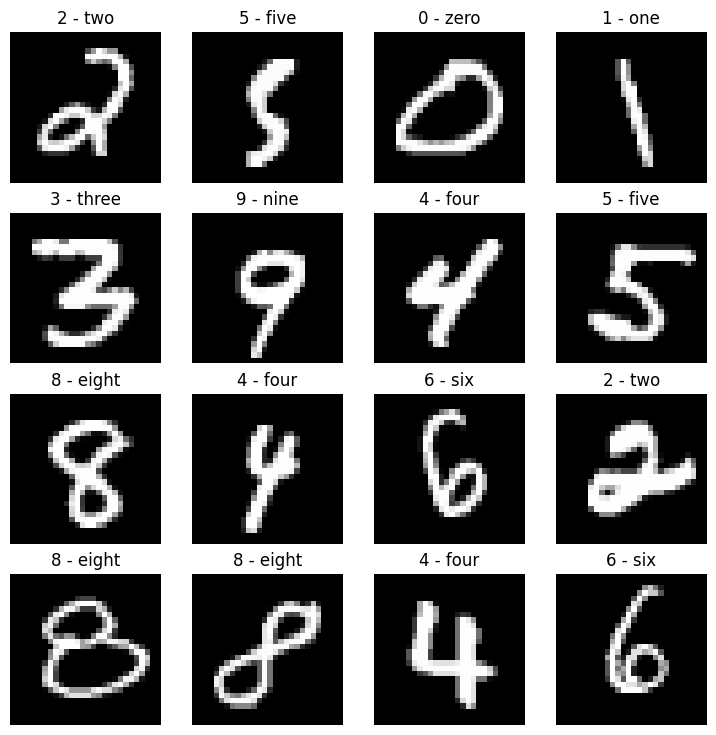

In [39]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  (image, label) = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  image = train_transform(image)
  plt.imshow(image.permute(1, 2, 0), cmap="gray")
  plt.title(classes[label])
  plt.axis(False)

# Dataloader

In [40]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Models

In [41]:
class TinyMNIST(nn.Module):
  def __init__(self):
    super().__init__()

    hidden = 40
    kernel = 3

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(1, hidden, 3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None),
        nn.ReLU()
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden, hidden, 3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(hidden, hidden, 3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None),
        nn.ReLU()
    )
    self.conv_block_4 = nn.Sequential(
        nn.Conv2d(hidden, hidden, 3, stride=1, padding=1, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.output = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden*7*7, 10)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.output(self.conv_block_4(self.conv_block_3(self.conv_block_2(self.conv_block_1(x)))))

In [42]:
model = TinyMNIST().to(device)

In [55]:
from torchinfo import summary

summary(model=TinyMNIST(), input_size = (1, 1, 28, 28), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
TinyMNIST (TinyMNIST)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (conv_block_1)              [1, 1, 28, 28]       [1, 40, 28, 28]      --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 40, 28, 28]      400                  True
│    └─ReLU (1)                          [1, 40, 28, 28]      [1, 40, 28, 28]      --                   --
├─Sequential (conv_block_2)              [1, 40, 28, 28]      [1, 40, 14, 14]      --                   True
│    └─Conv2d (0)                        [1, 40, 28, 28]      [1, 40, 28, 28]      14,440               True
│    └─ReLU (1)                          [1, 40, 28, 28]      [1, 40, 28, 28]      --                   --
│    └─MaxPool2d (2)                     [1, 40, 28, 28]      [1, 40, 14, 14]      --                   --
├─Sequential (conv_b

# Training

In [43]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

In [44]:
from tqdm.auto import tqdm
import time

train_losses = []
test_losses = []
test_accuracies = []

In [45]:
epochs = 10
program_starts = time.time()
for epoch in tqdm(range(epochs)):
  train_loss = 0
  for batch, (X, y) in enumerate(train_dataloader):
    model.train()
    X=X.to(device)
    y=y.to(device)
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #if batch%400 == 0:
      #print(f"Batch: {batch}/{len(train_dataloader)}")

  train_loss /= len(train_dataloader)
  train_losses.append(train_loss.cpu().detach().numpy())

  model.eval()
  test_loss = 0
  test_accuracy = 0
  with torch.inference_mode():
    for X, y in test_dataloader:
      X=X.to(device)
      y=y.to(device)
      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_accuracy += accuracy_fn(y, test_pred.argmax(dim=1))


    test_loss /= len(test_dataloader)
    test_losses.append(test_loss.cpu())

    test_accuracy /= len(test_dataloader)
    test_accuracies.append(test_accuracy)

  print(f"Epoch: {epoch+1} | Loss: {train_loss} | Test acc: {test_accuracy}%")


program_ends = time.time()

print(f"Elapsed: {program_ends-program_starts}s")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | Loss: 0.13192243874073029 | Test acc: 98.39257188498402%
Epoch: 2 | Loss: 0.045267440378665924 | Test acc: 98.93170926517571%
Epoch: 3 | Loss: 0.03299892693758011 | Test acc: 99.15135782747603%
Epoch: 4 | Loss: 0.023667069151997566 | Test acc: 98.77196485623003%
Epoch: 5 | Loss: 0.020254500210285187 | Test acc: 99.11142172523962%
Epoch: 6 | Loss: 0.015881594270467758 | Test acc: 99.19129392971246%
Epoch: 7 | Loss: 0.014013461768627167 | Test acc: 99.15135782747603%
Epoch: 8 | Loss: 0.01113806664943695 | Test acc: 99.22124600638978%
Epoch: 9 | Loss: 0.009703552350401878 | Test acc: 99.19129392971246%
Epoch: 10 | Loss: 0.009901120327413082 | Test acc: 99.17132587859425%
Elapsed: 149.9323012828827s


# Plots

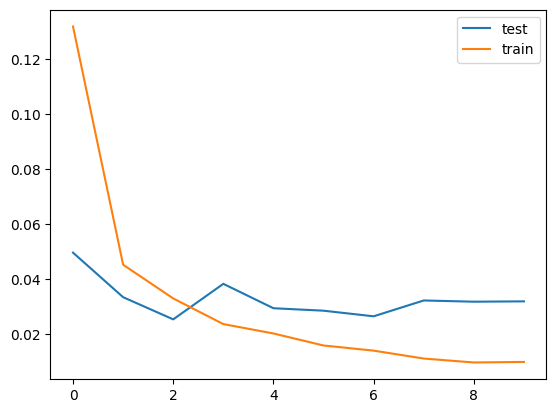

In [46]:
plt.plot(test_losses, label="test")
plt.plot(train_losses, label="train")
plt.legend()
plt.show()

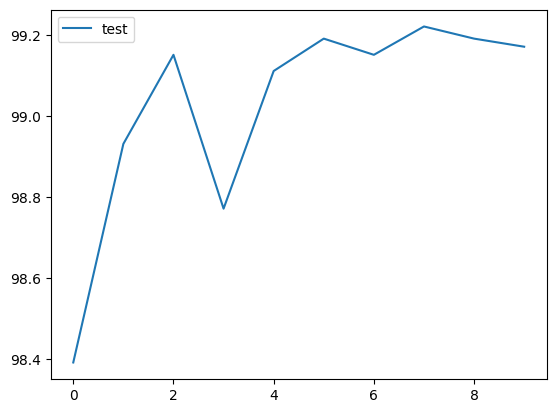

In [47]:
#plt.plot(train_accuracies, label="train")
plt.plot(test_accuracies, label="test")
plt.legend()
plt.show()

# Predictions

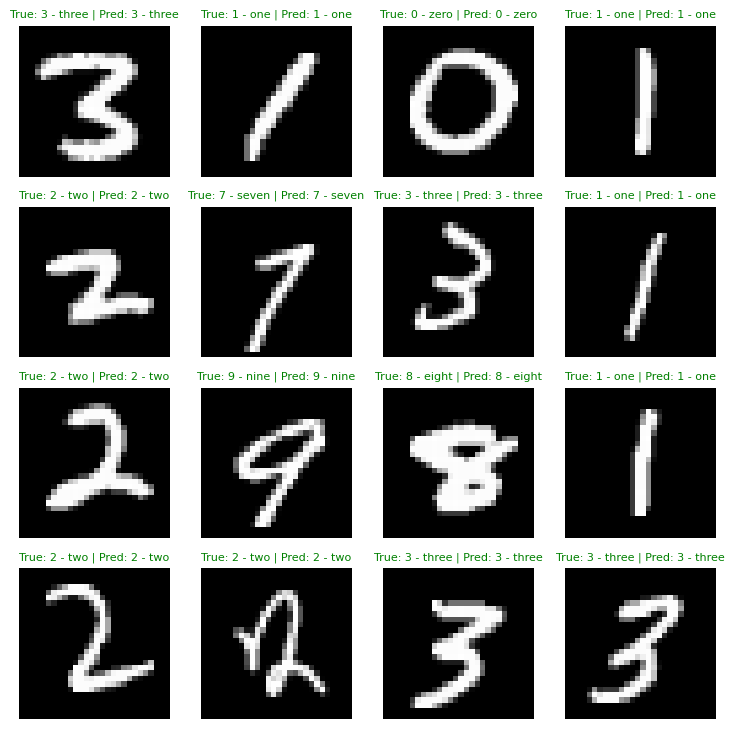

In [48]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(test_data), size=[1]).item()
  image, true_label = test_data[random_idx]

  predicted_label = model(image.unsqueeze(dim=0).to(device)).argmax(dim=1)

  fig.add_subplot(rows, cols, i)
  plt.imshow(image.permute(1, 2, 0), cmap="gray")
  if true_label == predicted_label:
    color = "g"
  else:
    color = "r"
  plt.title(f"True: {classes[true_label]} | Pred: {classes[predicted_label]}", fontsize=8, c=color)
  plt.axis(False)

# Confusion matrix

In [49]:
matrix = np.zeros((10, 10))

y_preds = []

for i in tqdm(range(len(test_data))):
  image, true_label = test_data[i]
  predicted_label = model(image.unsqueeze(dim=0).to(device)).argmax(dim=1)
  y_preds.append(predicted_label)
  matrix[true_label, predicted_label] += 1

  0%|          | 0/10000 [00:00<?, ?it/s]

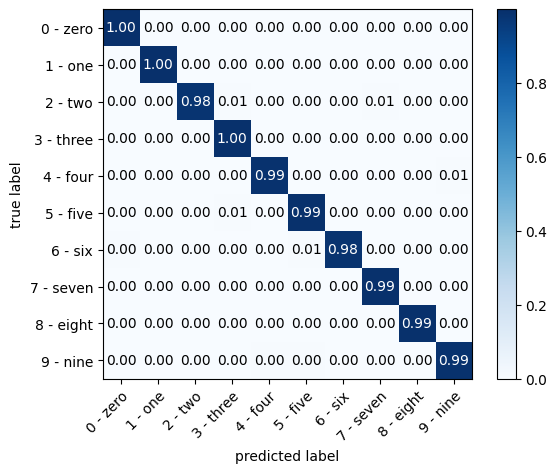

In [50]:
y_preds = torch.tensor(y_preds).squeeze()

true_labels = test_data.targets

confmat = ConfusionMatrix(task="multiclass", num_classes=10)
matrix = confmat(y_preds, true_labels).numpy()

fig, ax = plot_confusion_matrix(conf_mat=matrix, colorbar=True, show_absolute=False, show_normed=True, class_names=classes)
plt.show()